# Data Challenge 5

### Susan Currie Sivek

The goal of this data analysis is to better understand what groups/types of cardholders exist in order to offer each group a specific set of benefits, thereby reducing the costs of signup incentives. The data are from 6 months of cardholder activity.

This is an clustering problem -- can we find identifiable, distinctive groups among the cardholders based on their account activity?

In [1]:
# import necessary tools

import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline
import seaborn as sns

In [30]:
# read in and get an overall sense of the data
df = pd.read_csv('cc_info.csv')
df.drop('CUST_ID', axis=1, inplace=True)

In [37]:
df.rename(columns={'PURCHASES': 'PURCHASES_TOTAL', 'CASH_ADVANCE': 'CASH_ADVANCE_TOTAL', 'INSTALLMENTS_PURCHASES': 
                   'INSTALLMENTS_PURCHASES_TOTAL', 'ONEOFF_PURCHASES': 'ONEOFF_PURCHASES_TOTAL', 'PAYMENTS': 
                   'PAYMENTS_TOTAL', 'CASH_ADVANCE_TRX': 'CASH_ADVANCE_AVG', 'PURCHASES_TRX': 'PURCHASES_AVG'}, 
          inplace=True)

In [40]:
pandas_profiling.ProfileReport(df)

Number of variables,18
Number of observations,8636
Total Missing (%),0.0%
Total size in memory,1.2 MiB
Average record size in memory,144.0 B
Numeric,17
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,1


### Observations about the data

- The frequency features are provided as the "ratio of the last 12 months" in which the customer did each thing -- e.g., made a purchase, received a cash advance. All of these values would need to be zero, one, or multiples of 1/12. They are not. I'm not sure what to do about that.
- Lots of the data are provided to many decimal points, for some unknown reason, given that these are in dollars and cents. I suppose it doesn't hurt to have them there, but perhaps rounding them would be more efficient in a much larger dataset.
- There are quite a few zero values occurring for many variables, but this is still useful information, as opposed to simply missing data.
- ... with one exception: minimum_payments is missing 313 values. There is also one missing value for credit_limit. I will just drop these rows, since they represent such a small part of the overall dataset.
- The cash advance average amount information seems odd. It seems unlikely that so many people (over 1/3) would have average cash advance amounts below \\$10. I am skeptical that these data are correct. I will ignore these data.
- The cash_advance_frequency column has some values over 1. It doesn't make sense to have a percentage of months greater than 1. I need to check on this.
- The profiling report shows that oneoff_purchases and purchases are very highly correlated (0.91). I will likely drop the oneoff_purchases information from my analysis for this reason.
- Most of the customers (85.1\%) included in these data have been customers for one year (or more?). They may have unique patterns of usage, and this should be kept in mind.

In [32]:
# drop rows that are missing minimum payment and credit limit information
df.dropna(subset=['MINIMUM_PAYMENTS'], inplace=True, axis=0)
df.dropna(subset=['CREDIT_LIMIT'], inplace=True, axis=0)

In [48]:
df = df[df.CASH_ADVANCE_FREQUENCY <= 1] # there were only a few rows with the issue noted above; dropped them

In [50]:
# dropping CASH_ADVANCE_AVG due to strange values; dropping ONEOFF_PURCHASES_TOTAL due to high correlation
df.drop(['CASH_ADVANCE_AVG', 'ONEOFF_PURCHASES_TOTAL'], axis=1, inplace=True) 

/Users/ssivek/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [52]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,BALANCE,BALANCE_FREQUENCY,PURCHASES_TOTAL,INSTALLMENTS_PURCHASES_TOTAL,CASH_ADVANCE_TOTAL,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,PURCHASES_AVG,CREDIT_LIMIT,PAYMENTS_TOTAL,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1,0.310082,0.176887,0.122915,0.495128,-0.0872938,0.0643661,-0.0684325,0.444552,0.148838,0.535,0.323712,0.399009,-0.333352,0.0712886
BALANCE_FREQUENCY,0.310082,1,0.122804,0.114935,0.0886254,0.22857,0.187539,0.184601,0.181524,0.183328,0.0874752,0.0392101,0.132527,-0.156797,0.106189
PURCHASES_TOTAL,0.176887,0.122804,1,0.679206,-0.0533883,0.392848,0.497388,0.315827,-0.124505,0.688675,0.358884,0.606859,0.0938664,0.176282,0.0838097
INSTALLMENTS_PURCHASES_TOTAL,0.122915,0.114935,0.679206,1,-0.0656356,0.441046,0.211791,0.510989,-0.136003,0.626002,0.258502,0.385429,0.132196,0.178252,0.0825161
CASH_ADVANCE_TOTAL,0.495128,0.0886254,-0.0533883,-0.0656356,1,-0.218078,-0.0902684,-0.178047,0.631813,-0.0779673,0.303952,0.459884,0.14009,-0.158129,-0.0706996
PURCHASES_FREQUENCY,-0.0872938,0.22857,0.392848,0.441046,-0.218078,1,0.502076,0.862286,-0.316703,0.567032,0.122095,0.100552,0.00302578,0.305125,0.0498838
ONEOFF_PURCHASES_FREQUENCY,0.0643661,0.187539,0.497388,0.211791,-0.0902684,0.502076,1,0.143816,-0.118721,0.544378,0.295862,0.244254,-0.0303508,0.154014,0.0800256
PURCHASES_INSTALLMENTS_FREQUENCY,-0.0684325,0.184601,0.315827,0.510989,-0.178047,0.862286,0.143816,1,-0.268005,0.529022,0.0640374,0.0833434,0.0300979,0.249217,0.0636257
CASH_ADVANCE_FREQUENCY,0.444552,0.181524,-0.124505,-0.136003,0.631813,-0.316703,-0.118721,-0.268005,1,-0.136136,0.13157,0.185621,0.0998759,-0.260803,-0.127876
PURCHASES_AVG,0.148838,0.183328,0.688675,0.626002,-0.0779673,0.567032,0.544378,0.529022,-0.136136,1,0.274218,0.371479,0.0963531,0.15657,0.117981


In [53]:
# also extremely high correlation: purchases_frequency and purchases_installments_frequency (0.862)
# drop the latter
df.drop('PURCHASES_INSTALLMENTS_FREQUENCY', axis=1, inplace=True) 

In [54]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES_TOTAL,INSTALLMENTS_PURCHASES_TOTAL,CASH_ADVANCE_TOTAL,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,PURCHASES_AVG,CREDIT_LIMIT,PAYMENTS_TOTAL,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,95.40,0.000000,0.166667,0.000000,0.00,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,6442.945483,0.000000,0.000000,0.25,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,0.00,0.000000,1.000000,1.000000,0.00,12,7500.0,622.066742,627.284787,0.000000,12
4,817.714335,1.000000,16.00,0.00,0.000000,0.083333,0.083333,0.00,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,1333.28,0.000000,0.666667,0.000000,0.00,8,1800.0,1400.057770,2407.246035,0.000000,12


There are five other pairs of features that are correlated at 0.6 or above. If time permits, I'll see later if omitting one of each pair improves my model.

I think this is about as clean as I'm going to get this right now. Let's try to make these data into happy little clusters.

## Clustering to Define Cardholder Segments

Using PCA for dimensionality reduction here is tempting, but the results will not be interpretable in terms of understanding which features define the eventual segments. The goal here is not to predict the segment membership for future cardholders but rather to use existing data to inform ways to target existing cardholder groups. Therefore, it would be better to work with the original dataset.

I'll first use k-means clustering here, a method which should be able to detect any identifiable, distinctive groups among these cardholders.

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [63]:
# scale data to prepare for k-means

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

/Users/ssivek/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ssivek/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [134]:
# probably don't want too many different types of cardholder offers; keep the number of segments manageable

n_clusters = 5

In [135]:
kmeans = KMeans(n_clusters=n_clusters).fit(scaled_data) 

In [136]:
labels = kmeans.labels_
df['cluster'] = labels

Text(37.07022135416667, 0.5, 'Cash Advance Frequency')

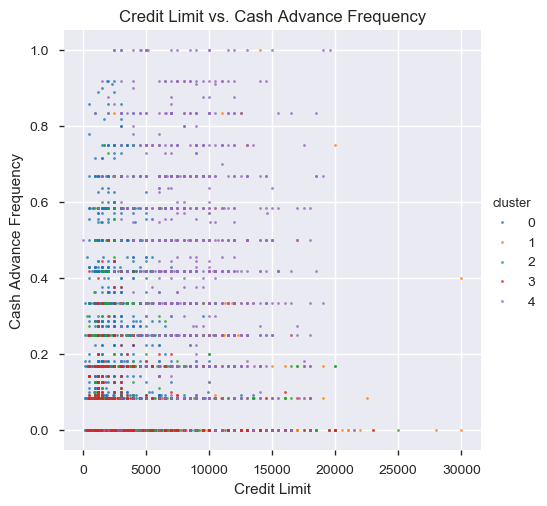

In [137]:
# let's make some plots
# assume that some defining features of a credit card user are their purchase frequency, credit limit

sns.lmplot('CREDIT_LIMIT', 'CASH_ADVANCE_FREQUENCY',
           data=df, 
           fit_reg=False, 
           hue="cluster",  
           scatter_kws={"marker": "D", 
                        "s": 4})
plt.title('Credit Limit vs. Cash Advance Frequency')
plt.xlabel('Credit Limit')
plt.ylabel('Cash Advance Frequency')

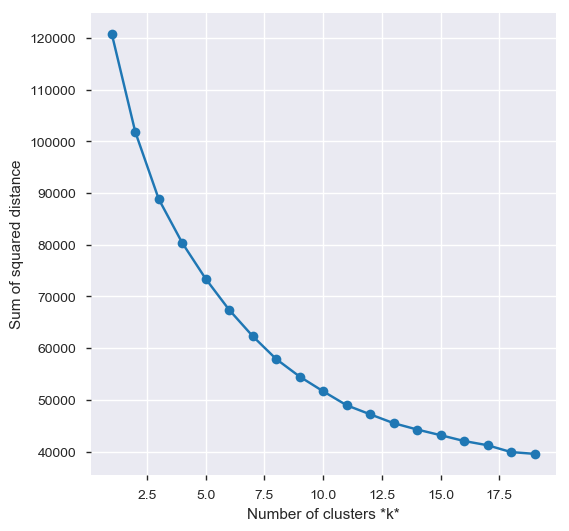

In [133]:
# Run the Kmeans algorithm and get the index of data points clusters
# code borrowed from https://t.ly/9JZL
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(scaled_data)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

It's hard to determine the optimal number of clusters from this plot. There seems to be little point in going beyond 10 clusters, at least. About half the overall loss of error comes around 4 clusters, so 5 is probably a good number to shoot for.

What are the defining qualities of the individuals in each cluster? Some additional descriptive statistics and plots may help.

In [142]:
clustered_df = df.groupby(['cluster'])

In [154]:
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES_TOTAL',
       'INSTALLMENTS_PURCHASES_TOTAL', 'CASH_ADVANCE_TOTAL',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'PURCHASES_AVG', 'CREDIT_LIMIT',
       'PAYMENTS_TOTAL', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE',
       'cluster'],
      dtype='object')

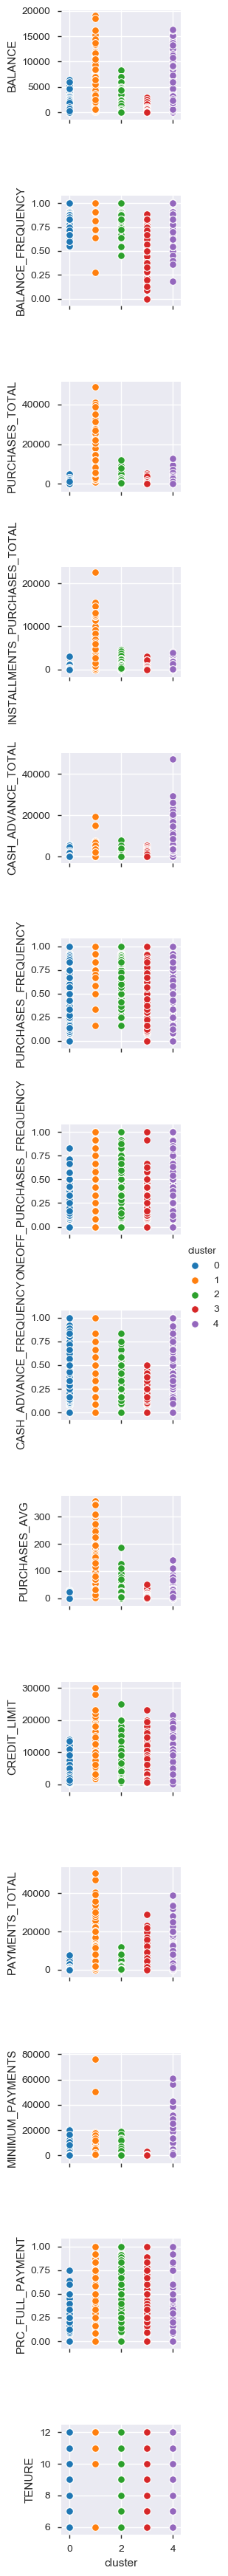

In [155]:
g = sns.pairplot(df, x_vars="cluster", y_vars=['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES_TOTAL',
       'INSTALLMENTS_PURCHASES_TOTAL', 'CASH_ADVANCE_TOTAL',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'PURCHASES_AVG', 'CREDIT_LIMIT',
       'PAYMENTS_TOTAL', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'], hue="cluster")

In [147]:
clustered_df['CREDIT_LIMIT'].mean()

cluster
0     3009.934766
1    10130.592105
2     4540.256223
3     3720.947968
4     8737.438281
Name: CREDIT_LIMIT, dtype: float64

In [148]:
clustered_df['BALANCE'].mean()

cluster
0    1457.876943
1    3951.293762
2     943.672132
3     138.767385
4    5373.249925
Name: BALANCE, dtype: float64

In [157]:
clustered_df['TENURE'].mean()

cluster
0    11.393006
1    11.957237
2    11.701438
3    11.402506
4    11.546326
Name: TENURE, dtype: float64

### Common Sense Simplification of Data

In [193]:
# things that, to me, distinguish types of credit card users:
# do they use the card; how much do they spend per purchase; how much do they need cash advances;
# credit limit as a proxy for creditworthiness; paying off statement balance

simple_df = df[['BALANCE_FREQUENCY', 'PURCHASES_AVG', 'CASH_ADVANCE_TOTAL', 'CREDIT_LIMIT', 'PRC_FULL_PAYMENT']]

In [194]:
simple_scaled_data = scaler.fit_transform(simple_df)

/Users/ssivek/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ssivek/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [195]:
# probably don't want too many different types of cardholder offers; keep the number of segments manageable
# elbow graph below shows 6 is a good number of clusters for explaining data without adding too much complexity

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters).fit(simple_scaled_data) 
labels = kmeans.labels_
simple_df['cluster'] = labels

/Users/ssivek/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


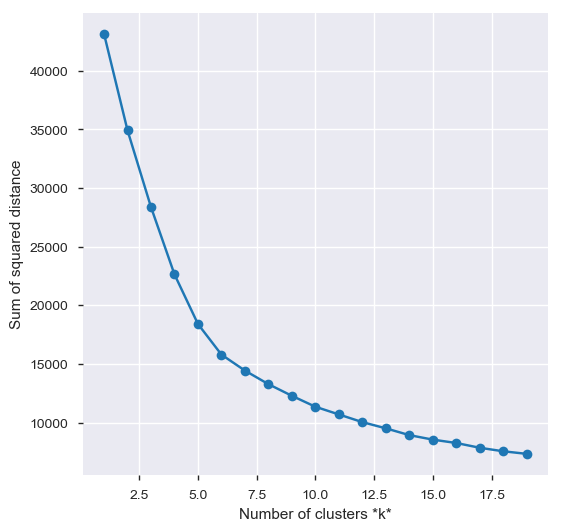

In [196]:
# Run the Kmeans algorithm and get the index of data points clusters
# code borrowed from https://t.ly/9JZL
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(simple_scaled_data)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Text(37.51778385416668, 0.5, 'Average Purchase')

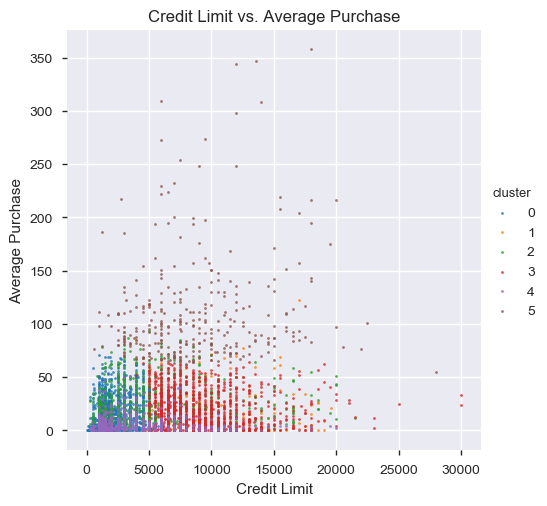

In [197]:
# try out a plot to see how cardholders are separated
# 'BALANCE_FREQUENCY', 'PURCHASES_AVG', 'CASH_ADVANCE_TOTAL', 'CREDIT_LIMIT', 'PRC_FULL_PAYMENT'

sns.lmplot('CREDIT_LIMIT', 'PURCHASES_AVG',
           data=simple_df, 
           fit_reg=False, 
           hue="cluster",  
           scatter_kws={"marker": "D", 
                        "s": 4})
plt.title('Credit Limit vs. Average Purchase')
plt.xlabel('Credit Limit')
plt.ylabel('Average Purchase')

In [198]:
clustered_simple_df = simple_df.groupby(['cluster'])

In [213]:
clustered_simple_df['BALANCE_FREQUENCY'].count()

cluster
0    4125
1     459
2    1037
3    1639
4    1043
5     325
Name: BALANCE_FREQUENCY, dtype: int64

In [199]:
bal_freq = clustered_simple_df['BALANCE_FREQUENCY'].mean()
purch_avg = clustered_simple_df['PURCHASES_AVG'].mean()
cash_total = clustered_simple_df['CASH_ADVANCE_TOTAL'].mean()
limit = clustered_simple_df['CREDIT_LIMIT'].mean()
full_pmt = clustered_simple_df['PRC_FULL_PAYMENT'].mean()

In [200]:
cluster_means = pd.concat([bal_freq, purch_avg, cash_total, limit, full_pmt], axis=1)

In [214]:
cluster_means['group_names'] = ['GENERIC_SPENDERS', 'CASH_ADVANCE_LOVERS', 'PAYERS_IN_FULL', 'CASH_AND_CREDIT', 
                               'LOW_UTILIZATION', 'BIG_SPENDER']

In [215]:
cluster_means

,BALANCE_FREQUENCY,PURCHASES_AVG,CASH_ADVANCE_TOTAL,CREDIT_LIMIT,PRC_FULL_PAYMENT,group_names
cluster,,,,,,
0,0.972934,9.449697,595.024076,2354.472360,0.041207,GENERIC_SPENDERS
1,0.947777,8.091503,7696.042136,8853.485839,0.053451,CASH_ADVANCE_LOVERS
2,0.887670,21.025072,74.402673,4758.421291,0.829757,PAYERS_IN_FULL
3,0.973957,15.204393,1115.484075,8494.389595,0.046927,CASH_AND_CREDIT
4,0.415888,4.623202,445.358886,3392.226483,0.172156,LOW_UTILIZATION
5,0.992951,109.455385,612.735937,8698.000000,0.197855,BIG_SPENDER


## Identified Cardholder Types

The above dataframe shows how these six clusters differ in card usage behavior. The below is a summary that's easier to understand, with rounded dollar amounts:

- Cluster 0, *GENERIC_SPENDERS* (4125 cardholders): almost always has a balance; \\$9 average purchase; \\$600 total cash advances; lowest mean credit limit; least likely to pay statement balance in full

- Cluster 1, *CASH_ADVANCE_LOVERS* (459 cardholders): almost always has a balance; \\$8 average purchase; \\$7700 total cash advances; highest mean credit limit; unlikely to pay statement balance in full

- Cluster 2, *PAYERS_IN_FULL* (1037 cardholders): somewhat less likely to have a balance; \\$21 average purchase; \$74 total cash advances; moderate mean credit limit; most likely to pay statement balance in full

- Cluster 3, *CASH_AND_CREDIT*  (1639 cardholders): almost always has a balance; \\$15 average purchase; \\$1115 total cash advances; higher credit limit; second least likely to pay statement balance in full

- Cluster 4, *LOW_UTILIZATION* (1043 cardholders): has a balance less than half the year; \\$5 average purchase; \$445 total cash advances; next-to-lowest credit limit; pays statement balance in full a couple of times each year

- Cluster 5, *BIG_SPENDERS* (325 cardholders): nearly always has a balance; \\$109 average purchase; \\$613 total cash advances; next-to-highest credit limit; pays statement balance in full a couple of times each year

The boxplots below may help clarify where each group differs from the others.

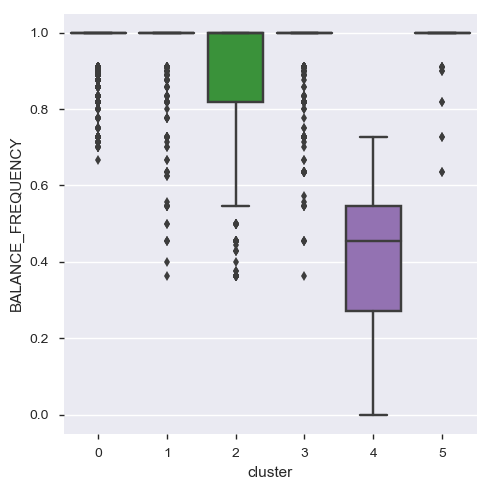

In [207]:
# Cluster 4, the Low Utilization group, stands out for infrequently having a balance

sns.catplot(x="cluster", y="BALANCE_FREQUENCY", kind="box", data=simple_df);

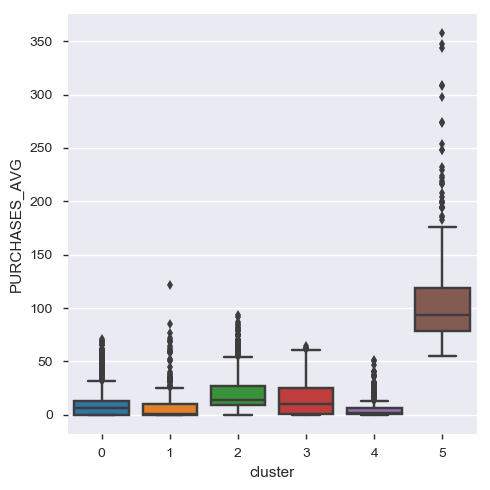

In [208]:
# Cluster 5, the Big Spenders, stand out for their notably higher average purchase amount
sns.catplot(x="cluster", y="PURCHASES_AVG", kind="box", data=simple_df);

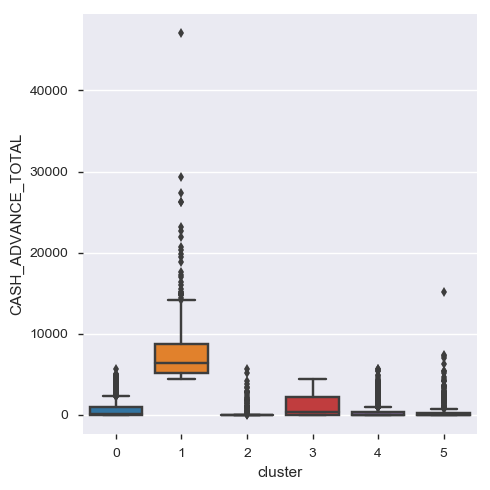

In [209]:
# Cluster 1, the Cash Advance Lovers, rise above the pack for their large cash borrowing

sns.catplot(x="cluster", y="CASH_ADVANCE_TOTAL", kind="box", data=simple_df);

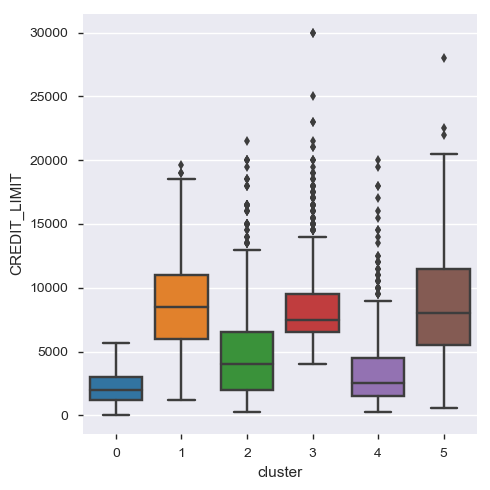

In [210]:
# Considering credit limit as a proxy for creditworthiness, we see variation across clusters in their assigned limits
# The other behaviors that define these groups are present across credit limit levels, though there is
# a bit of a higher/lower distinction between 0, 2, and 4 versus 1, 3, 5

sns.catplot(x="cluster", y="CREDIT_LIMIT", kind="box", data=simple_df);

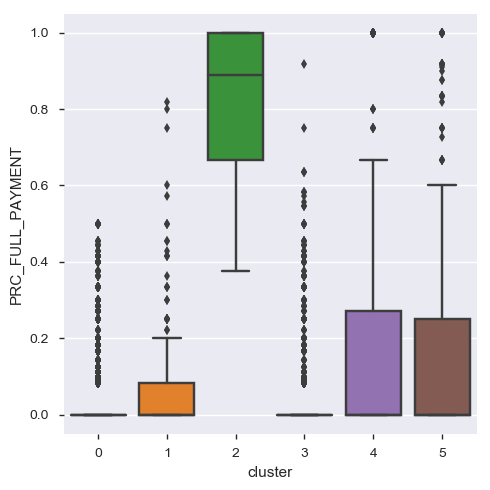

In [212]:
# Cluster 2, the Payers in Full, stands out here for frequently paying the full statement balance

sns.catplot(x="cluster", y="PRC_FULL_PAYMENT", kind="box", data=simple_df);

## Wrapping Up: Next Steps and Recommendations

This analysis represents only an initial step toward understanding these customers' activities. Only about half of the cardholders fit into a more specific cluster, and so it would be good to further understand the "Generic Spenders" category described above. A separate analysis just of that group might reveal more interesting patterns that could be capitalized upon.

I would also engineer a feature to capture credit usage by calculating the ratio of balance to credit limit. This is a measure often used in creditworthiness ratings.

In terms of other analysis options, I would also consider using HDBSCAN to cluster these cardholders. It doesn't have to classify outliers, and it doesn't require specifying a number of clusters in advance. I might also try hierarchical clustering because it can be easily visualized and so perhaps easier to communicate to this SVP.